# Forecasting forced displacement



In [1]:
import pandas as pd
from time import time
import os
import json
import pickle
import numpy as np 
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

# Data transforms

<TBC>

In [2]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if d['name']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))

Sources            : 19
Shape              : 924558 (rows) 6 (columns)
Geographies        : 568
Indicators         : 142
Temporal coverage  : 1789 -> 2019
Null values        : 1421

Loaded data in 1.18 sec.
Long form of size  : 35901 (rows) 144 (columns)


In [3]:
# Define the subset to work with

countries = ['AFG', 'MMR']

# Features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP']
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED']
target = ['DRC.TOT.DISP']
allfeatures = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat))

mmr_data = [f for f in allfeatures if f.startswith('MMR.NSO')]

features = {'AFG': list(set(allfeatures) - set(mmr_data)), 'MMR': allfeatures}

# filter
c1 = data['Country Code'].isin(countries)
c2 = data.year >= 1950

df = data.loc[c1 & c2, idx + allfeatures + target]
print("Filtered data has {} rows, {} columns.".format(*df.shape))

Filtered data has 140 rows, 129 columns.


In [4]:
# data quality and coverage

for c in countries:
    idx = df['Country Code'] == c
    print("\n" + c + " ({} obs)".format(sum(idx)))
    print("Time period: {} -> {}".format(df.loc[idx, 'year'].min(), df[idx].year.max()))
    datapoints = df[idx].notna().sum() # * 100 / len(df[idx])
    print(datapoints.sort_values(ascending=False)[:])


AFG (70 obs)
Time period: 1950 -> 2019
Indicator Code
Country Code      70
year              70
SP.PV.CIV.VIOL    69
SP.POL.DEM        69
SP.PV.ETH.WAR     69
                  ..
UC.EVT.RAKH        0
SI.POV.GINI        0
MMR.NSO.ATST       0
MMR.NSO.AARST      0
MMR.NSO.AT         0
Length: 129, dtype: int64

MMR (70 obs)
Time period: 1950 -> 2019
Indicator Code
Country Code         70
year                 70
SP.PV.CIV.VIOL       69
SP.POL.SCR.TWO       69
SP.POL.DEM           69
                     ..
ER.GDP.FWTL.M3.KD     2
SI.POV.GINI           1
WFP.PRC.WHT           0
ACLED.FATALITIES      0
ACLED.COUNT           0
Length: 129, dtype: int64


/Users/rahul/anaconda3/envs/mm4sight/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7847: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


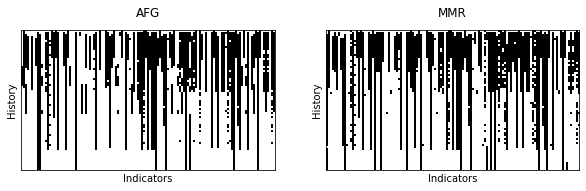

In [5]:

fig, ax = plt.subplots(1, len(countries), 
                       figsize=(10, 4), 
                       sharex='col', sharey='row')
for i, c in enumerate(countries):
    
    idx = df['Country Code'] == c
    ax[i].spy(df.loc[idx, allfeatures + target].values, origin='lower')
    ax[i].set_xlabel("Indicators")
    ax[i].set_ylabel("History")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(c)
plt.savefig("img/coverage.png", dpi=200, bbox_inches='tight')

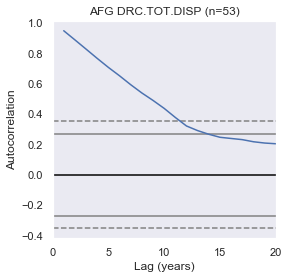

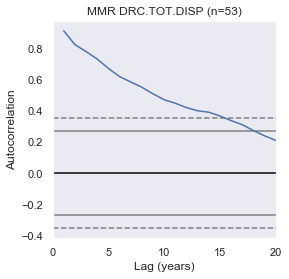

In [6]:
from pandas.plotting import autocorrelation_plot
sns.set(font_scale=1.0)

TARGETS = ['DRC.TOT.DISP']

for c in countries:
    fig, ax = plt.subplots(1, 1, 
                           figsize=(4,4), 
                           sharex='col', sharey='row')

    for t in TARGETS:

        idx = df['Country Code'] == c
        tmp = df.loc[idx, ['year', t]]
        tmp = tmp[~tmp[t].isnull()]

        autocorrelation_plot(tmp, ax=ax)
        ax.set_title("{} {} (n={})".format(c, t, len(tmp)))
        ax.set_xlim([0, 20])
        ax.set_xlabel('Lag (years)');

    plt.show()
    plt.close()
    
    # plt.savefig("img/autocorrelation-{}.png".format(c), dpi=200, bbox_inches='tight')
    # plt.close()



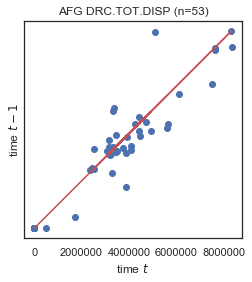

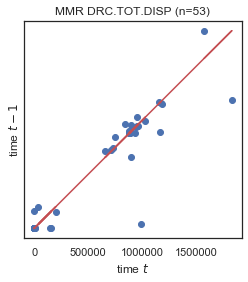

In [7]:
# Scatter plots (per DRC request)
sns.set(style="white")


for c in countries:
    fig, ax = plt.subplots(1, 1, 
                       figsize=(10, 4))
    
    for i, t in enumerate(TARGETS):

        idx = df['Country Code'] == c
        tmp = df.loc[idx, ['year', t]]
        tmp = tmp[~tmp[t].isnull()]

        tmp.sort_values(by='year', inplace=True)
        tmp['T-1'] = tmp[t].shift(1)

        ax.scatter(tmp[t], tmp['T-1'])
        ax.plot(tmp[t], tmp[t], '-r')
        ax.set_aspect('equal', adjustable='box')
        ax.set_title("{} {} (n={})".format(c, t, len(tmp)))
        ax.set_yticks([], [])
        ax.set_ylabel('time $t-1$')
        ax.set_xlabel('time $t$');
        
    plt.show()
    #plt.savefig("img/scatter-{}.png".format(c), dpi=200, bbox_inches='tight')
    #plt.close()


# Features

In [8]:
def lag_variables(data, var, lag):
    """
    Append lagged variables to frame.
    
    data - pandas data frame
    var - list of variable names to lag
    lag - integer
    
    """
    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name

def get_diff(fr):
    
    fr = fr.sort_values(by='year')
    tmp = fr.year
    res = fr.diff()
    res['year'] = tmp
    res.fillna(-10^9, inplace=True)
    return res


def generate_features(data, 
                      training_years,
                      forecast_year,
                      country,
                      target_var,
                      feature_var,
                      differencing=False):
    """ 
    Generate a feature set for training/test
    
    data: pandas Dataframe in long form with all indicator variables
    training_years: Tuple showing min-max years to train on, e.g. (1995, 2010)
    forecast_year: test year, (2011)
    country: ISO3 code (e.g. 'AFG')
    target_var: variable name to forecast e.g. 'FD'
    feature_var: list of variables to include
    differencing: all features are differences

    returns: 
        Dictionary with training, test data, along with the baseline
        Baseline is the latest flow in the training data.
    """
    
    # build the changes feature set
    if differencing:
        idx = data['Country Code'] == country
        data = data[idx].groupby(['Country Code']).apply(get_diff)
        data = data.reset_index()
        
    true_feature_var = [f for f in feature_var]
    print("Total # Features: {}".format(len(true_feature_var)))
    
    dcols = data.columns
    assert target_var in dcols,\
        "Target variable '{}' must be in data frame.".format(target_var)
    
    for fv in feature_var:
        assert fv in dcols,\
            "Feature variable '{}' does not exist.".format(fv)
        
    # Get the poor man's forecast as baseline
    dt = forecast_year - training_years[1]
    bv = data.loc[(data.year == forecast_year - dt) & 
                  (data['Country Code'] == country), target_var].values[0]
    
    if not differencing:
        print("Baseline value: {} (year {})".format(bv, forecast_year - dt))
    
    # Get the true value
    try:
        tr = data.loc[(data.year == forecast_year) & 
                      (data['Country Code'] == country), target_var].values[0]
        # print("True value: {} (year {})".format(tr, forecast_year))
    except IndexError:
        tr = np.nan
    
    # Target variable offset by a year (y_(t+dt))
    data, varname = lag_variables(data, [target_var], dt)
    true_target_var = varname[0]
    
    # Temporal filter: since the target variable is lagged, the training
    # year is one year prior.
    yl, yu = training_years
    t1 = data.year.between(*(yl, yu - dt))
    v1 = data.year == forecast_year - dt 
    
    # Spatial filter
    t2 = data['Country Code'] == country
        
    # For an AR(1) we just include current year value
    if dt > 0:
        true_feature_var += [target_var]

    # Handle the missing features
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Training data
    Xt = data.loc[t1 & t2, true_feature_var]
    yt = data.loc[t1 & t2, true_target_var]
    print("Xt shape: {} rows, {} cols".format(*Xt.shape))
    
    # Forecast/validation data
    Xv = data.loc[v1 & t2, true_feature_var]
    yv = data.loc[v1 & t2, true_target_var]
    
    # Drop missing training labels
    idx = ~pd.isnull(yt)
    yt = yt[idx]
    Xt = Xt[idx]
    
    return {'data': (Xt, yt, Xv, yv), 'baseline': bv, 'true': tr, 'Country code': c}

# Models

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Variables to predict
TARGETS = ['DRC.TOT.DISP']

# Years ahead to predict
lag = [0, 1, 2, 3, 4, 5, 6]
PERIODS = [{'train_years': (1995, Y - lg), 
            'predict_year': Y,
            'lag': lg} for Y in np.arange(2010, 2016, 1) for lg in lag]

# Models to evaluate
MODELS = [('XGBoost-0.001', Pipeline([("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                        random_state=42,
                                                                 max_depth=6, 
                                                                 learning_rate=0.001, 
                                                                 loss='ls'))]))]
"""
         ("SVM - standardized", Pipeline([("Standardize",  RobustScaler(quantile_range=(10, 90))),
                                         ("Estimator", SVR(gamma='auto'))]))]

         ("SVM - log response", TransformedTargetRegressor(regressor=SVR(gamma='auto'), 
                                                          func=np.log1p,
                                                            inverse_func=np.expm1)),
         ("SVM - log+robust", TransformedTargetRegressor(regressor=Pipeline([("Standardize",  RobustScaler(quantile_range=(10, 90))),
                                         ("Estimator", SVR(gamma='auto'))]), 
                                                          func=np.log1p,
                                                            inverse_func=np.expm1))]
""";


In [10]:
results = []
batch = 0
start_time = time()

for c in countries:
    for p in PERIODS:

        batch += 1

        # Generate problem instance
        d = generate_features(df, 
                  p['train_years'],
                  p['predict_year'],
                  c,
                  TARGETS[0],
                  features[c])
        d2 = generate_features(df, 
                             p['train_years'], p['predict_year'], 
                              c, TARGETS[0], features[c], differencing=True)

        Xt, yt, Xv, yv = d['data']
        Xdt, ydt, Xdv, ydv = d2['data']

        for lbl, clf in MODELS:

            M = {}
            M['batch'] = batch
            M['period'] = p
            M['lag'] = p['lag']
            M['target'] = "FORCED_DISPLACEMENT" 
            M['baseline'] = d['baseline']
            M['true'] = yv.values[0]
            M['country'] = c
            
            # And finally run - base model
            M['model'] = lbl

            clf.fit(Xt, yt)
            fc = clf.predict(Xv)
            M['forecast_base'] = fc[0]
        
            # differencing run
            clf.fit(Xdt, ydt)
            fd = clf.predict(Xdv)
            M['forecast_diff'] = fd[0] + d['baseline']
            
            # ensemble - mean
            M['forecast'] = 0.5 * (fc[0] + fd[0] + d['baseline'])
            
            # MAE
            M['mae'] = metrics.mean_absolute_error(yv, [M['forecast']])
            results.append(M)


with open("result.pkl", 'wb') as outfile:
    pickle.dump(results, outfile)
    
print("Done with {} runs in in {:3.2f} sec.".format(len(results), time() - start_time))

Total # Features: 112
Baseline value: 3444902.0 (year 2010)
Xt shape: 16 rows, 112 cols
Total # Features: 112
Xt shape: 16 rows, 112 cols
Total # Features: 112
Baseline value: 3216014.0 (year 2009)
Xt shape: 14 rows, 113 cols
Total # Features: 112
Xt shape: 14 rows, 113 cols
Total # Features: 112
Baseline value: 3093408.0 (year 2008)
Xt shape: 12 rows, 113 cols
Total # Features: 112
Xt shape: 12 rows, 113 cols
Total # Features: 112
Baseline value: 3274160.0 (year 2007)
Xt shape: 10 rows, 113 cols
Total # Features: 112
Xt shape: 10 rows, 113 cols
Total # Features: 112
Baseline value: 2354868.0 (year 2006)
Xt shape: 8 rows, 113 cols
Total # Features: 112
Xt shape: 8 rows, 113 cols
Total # Features: 112
Baseline value: 2457538.0 (year 2005)
Xt shape: 6 rows, 113 cols
Total # Features: 112
Xt shape: 6 rows, 113 cols
Total # Features: 112
Baseline value: 2531520.0 (year 2004)
Xt shape: 4 rows, 113 cols
Total # Features: 112
Xt shape: 4 rows, 113 cols
Total # Features: 112
Baseline value: 31

Total # Features: 126
Baseline value: 657751.0 (year 2008)
Xt shape: 10 rows, 127 cols
Total # Features: 126
Xt shape: 10 rows, 127 cols
Total # Features: 126
Baseline value: 713339.0 (year 2007)
Xt shape: 8 rows, 127 cols
Total # Features: 126
Xt shape: 8 rows, 127 cols
Total # Features: 126
Baseline value: 729142.0 (year 2006)
Xt shape: 6 rows, 127 cols
Total # Features: 126
Xt shape: 6 rows, 127 cols
Total # Features: 126
Baseline value: 1165796.0 (year 2013)
Xt shape: 19 rows, 126 cols
Total # Features: 126
Xt shape: 19 rows, 126 cols
Total # Features: 126
Baseline value: 891004.0 (year 2012)
Xt shape: 17 rows, 127 cols
Total # Features: 126
Xt shape: 17 rows, 127 cols
Total # Features: 126
Baseline value: 888738.0 (year 2011)
Xt shape: 15 rows, 127 cols
Total # Features: 126
Xt shape: 15 rows, 127 cols
Total # Features: 126
Baseline value: 883940.0 (year 2010)
Xt shape: 13 rows, 127 cols
Total # Features: 126
Xt shape: 13 rows, 127 cols
Total # Features: 126
Baseline value: 899259

In [11]:
import numpy as np

with open("result.pkl", 'rb') as outfile:
    print("Using cached results.")
    results = pickle.load(outfile)
    
df_acc = pd.DataFrame(results)

#lagger = [1, 2, 3]
#df_acc = df_acc[df_acc.lag.isin(lagger)]

def mape(t, y): return np.mean(np.abs((t - y) / t))
    
def quality(x):
    
    y_pred = x.forecast
    y_pred_base = x.forecast_base
    y_pred_diff = x.forecast_diff
    y_true = x.true
    y_baseline = x.baseline
    
    return pd.Series({
            'mape-pred-base': mape(y_true, y_pred_base),
            'mape-pred-diff': mape(y_true, y_pred_diff),
            'mape-pred': mape(y_true, y_pred),
            'mape-baseline': mape(y_true, y_baseline)})

groups = df_acc.groupby(['country', 'model', 'lag']).apply(quality)

(groups
 .style
 .set_properties(**{'text-align': 'right'})
 .format({"mape-{}".format(c): "{:.1%}" for c in ['pred', 'baseline', 'pred-base', 'pred-diff']}))

Using cached results.


In [12]:
from random import sample

def confidence_interval(D, alpha=0.95, resample=1000):
    """
    Empirical bootstrapped confidence interval for distribution
    D - source distribution
    alpha - 95% confidence interval for mean
    resample - number of resamples to perform
    """
    # resample
    C = [np.mean(np.random.choice(D, len(D))) for i in np.arange(0,resample)]

    p1 = ((1.0-alpha)/2.0) * 100
    p2 = (alpha+((1.0-alpha)/2.0)) * 100
    
    lower, upper = np.percentile(C, p1), np.percentile(C, p2)
    
    return lower, upper
    
def CI(x):
    l, u = confidence_interval(x.mae)
    return pd.Series({'lower': l, 'upper': u})

idx = df_acc.model == 'XGBoost-0.001'
tmp = df_acc[idx].groupby(['country', 'model', 'lag']).apply(CI)
CI = tmp.reset_index(level=[1]).drop(columns='model').to_dict(orient='index')
CI

{('AFG', 0): {'lower': 12390.965370054744, 'upper': 64437.80837510606},
 ('AFG', 1): {'lower': 160740.0981719205, 'upper': 466392.4016075477},
 ('AFG', 2): {'lower': 111851.00426710495, 'upper': 528171.8897589998},
 ('AFG', 3): {'lower': 95639.28183204208, 'upper': 404523.44103756134},
 ('AFG', 4): {'lower': 164814.48311234656, 'upper': 671648.8477801436},
 ('AFG', 5): {'lower': 127904.30958471743, 'upper': 535500.3065692174},
 ('AFG', 6): {'lower': 250024.34629614907, 'upper': 699698.629243142},
 ('MMR', 0): {'lower': 13639.804364762706, 'upper': 59565.458177752924},
 ('MMR', 1): {'lower': 23946.952816248555, 'upper': 171855.57715129727},
 ('MMR', 2): {'lower': 59655.55709890798, 'upper': 243613.75243685514},
 ('MMR', 3): {'lower': 119919.03446089146, 'upper': 270571.0093457196},
 ('MMR', 4): {'lower': 159950.86349430974, 'upper': 274641.9429687769},
 ('MMR', 5): {'lower': 132694.79516337076, 'upper': 323040.355813576},
 ('MMR', 6): {'lower': 104023.54701895341, 'upper': 367393.932053

In [13]:
from itertools import product

# selected model

clf = Pipeline([("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                        random_state=42,
                                                                 max_depth=6, 
                                                                 learning_rate=0.1, 
                                                                 loss='ls'))])

BASE_YEAR = 2018
result = []

for c in countries:
    
    curr_for = None
    
    for lg in lag:

    
            # Generate problem instance
        d = generate_features(df, (1995, BASE_YEAR), BASE_YEAR + lg, c,
                  "DRC.TOT.DISP",
                  features[c])

        d2 = generate_features(df, 
                         (1995, BASE_YEAR), BASE_YEAR + lg, c,
                          "DRC.TOT.DISP", features[c], differencing=True)
        
        Xt, yt, Xv, yv = d['data']
        Xdt, ydt, Xdv, ydv = d2['data']
        
        # Fit and predict
        clf.fit(Xt, yt)
        fc = clf.predict(Xv)
        
        # differencing run
        clf.fit(Xdt, ydt)
        fd = clf.predict(Xdv)
        
        if curr_for is None:
            curr_for = d['baseline']

        M = {}
        fc_diff = fd[0] + curr_for
        curr_for = fc_diff
        
        M['truth'] = yv.values[0]
        M['country'] = c
        M['year'] = BASE_YEAR + lg
        M['forecast'] = fc[0]
        
        # ensemble - mean
        #M['forecast'] = 0.5 * (fc[0] + fc_diff)
            
        # CI
        key = c, lg
        rn = (CI[key]['upper'] - CI[key]['lower'])/2.0
        M['CI_low'] = M['forecast'] - rn
        M['CI_high'] = M['forecast'] + rn

        result.append(M)
        
        

Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 24 rows, 112 cols
Total # Features: 112
Xt shape: 24 rows, 112 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 23 rows, 113 cols
Total # Features: 112
Xt shape: 23 rows, 113 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 22 rows, 113 cols
Total # Features: 112
Xt shape: 22 rows, 113 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 21 rows, 113 cols
Total # Features: 112
Xt shape: 21 rows, 113 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 20 rows, 113 cols
Total # Features: 112
Xt shape: 20 rows, 113 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 19 rows, 113 cols
Total # Features: 112
Xt shape: 19 rows, 113 cols
Total # Features: 112
Baseline value: 5589362.0 (year 2018)
Xt shape: 18 rows, 113 cols
Total # Features: 112
Xt shape: 18 rows, 113 cols
Total # Features: 126
Baseline val

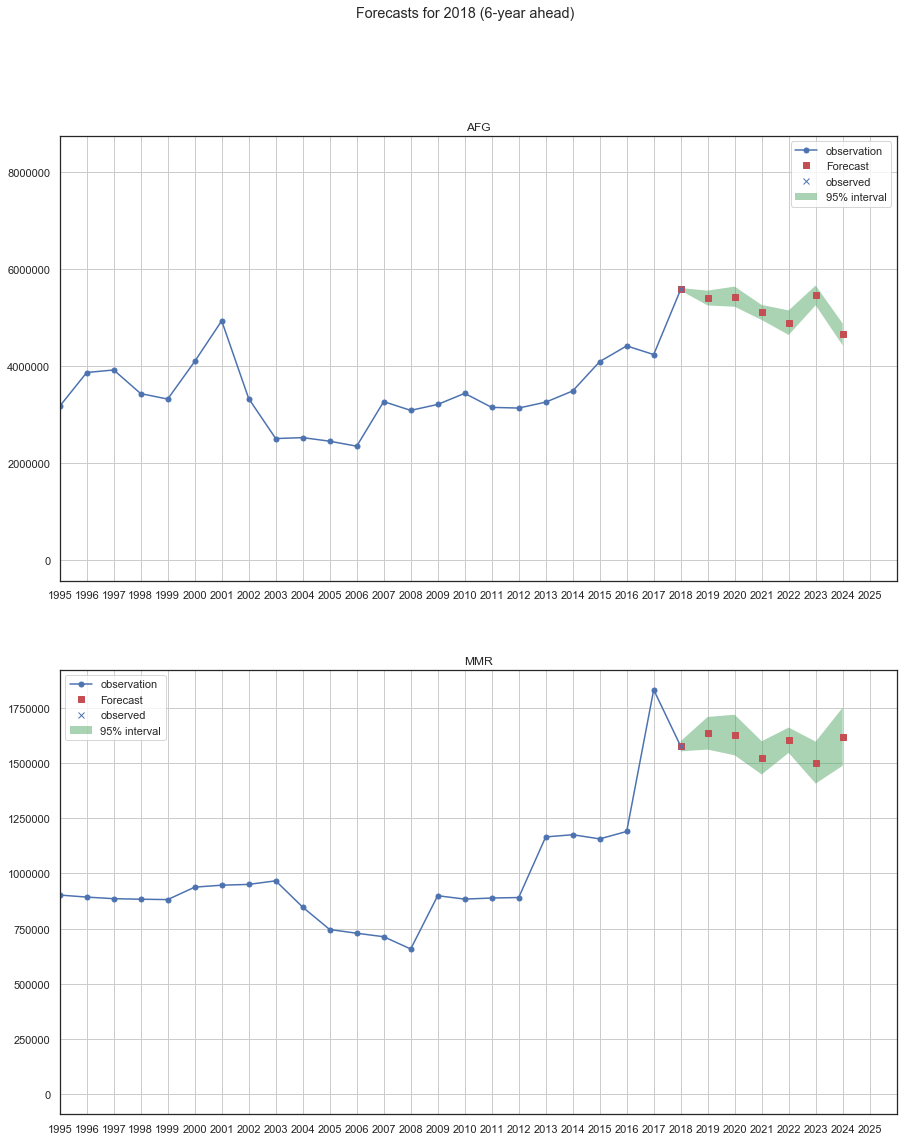

In [14]:
f, axarr = plt.subplots(len(countries), figsize=(15, 18), sharex=False)

pred = pd.DataFrame(result)
for i, c in enumerate(countries):
    
    # plot raw
    idx = (df['Country Code'] == c) & (df['year'] <= BASE_YEAR)
    obs_x = df.loc[idx, 'year']
    obs_y = df.loc[idx, 'DRC.TOT.DISP']
    axarr[i].plot(obs_x, obs_y, '-b.', markersize=10, label='observation')
    
    # plot the predictions
    c1 = pred.country == c
    pred_x = pred.loc[c1, 'year'].values
    pred_y = pred.loc[c1, 'forecast'].values
    true_y = pred.loc[c1, 'truth'].values
    ci_low_y = pred.loc[c1, 'CI_low'].values
    ci_high_y = pred.loc[c1, 'CI_high'].values
    
    axarr[i].plot(pred_x, pred_y, 'rs', label=u'Forecast')
    axarr[i].fill(np.concatenate([pred_x, pred_x[::-1]]),
         np.concatenate([ci_high_y, ci_low_y[::-1]]),
         alpha=.5, fc='g', ec='None', label='95% interval')
    
    # true value
    # TODO: fix bug that includes future unobserved values
    lastdata = 2018
    idx = pred_x <= lastdata
    axarr[i].plot(pred_x[idx], true_y[idx], 'xb', label=u'observed')
    axarr[i].grid(True)
    axarr[i].legend(loc=0)
    axarr[i].set_xlim([1995, BASE_YEAR + 8])
    axarr[i].set_xticks(np.arange(1995, BASE_YEAR + 8, 1))
    axarr[i].set_title(c)

plt.suptitle("Forecasts for {} ({}-year ahead)".format(BASE_YEAR, len(lag)-1));